# WS vs Full — Option 2A (Full Spectrum) Gate Simulation

This is the **full, annotated** notebook to compare:

- **WS** effective blockade model (single shifted doubly-excited level with shift B).
- **Full Option 2A**: diagonalize the **full ARC pair-interaction matrix** m(R) (full pair basis),
  and use all interaction eigenchannels |nu> with overlaps c_nu = <rr|nu>.

Gate protocol: **pi - 2pi - pi** (control pi, target 2pi, control pi).

Included diagnostics:
- Pair basis dimension and rr_index
- Completeness: sum |c_nu|^2 ~ 1 (Option 2A)
- Robust leakage-aware fidelities with best local-Z frame alignment

Optional speed blocks at the end:
- caching spectra per R
- parallelization over R (process-based) with deterministic ordering and thread controls

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.linalg import polar
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import expm_multiply

from arc import Rubidium87, PairStateInteractions

TWOPI = 2*np.pi
def MHz_to_Hz(x): return float(x)*1e6

## 0) Configuration

In [15]:
# Laser-addressed Rydberg state (defines the bare |rr> pair state)
ryd = dict(n=60, l=1, j=1.5, mj=1.5)  # 60P3/2, mj=3/2
theta, phi = 0.0, 0.0

# ARC basis controls
dn, dl = 5, 5
deltaMax_GHz = 40.0
interactionsUpTo = 1

# Sweeps
R_um_grid = np.linspace(1.0, 5.0, 20)
R0_um = 2.0

Omega_2pi_MHz_default = 30.0
Omega_default = TWOPI * MHz_to_Hz(Omega_2pi_MHz_default)  # rad/s

Omega_2pi_MHz_scan = np.linspace(5.0, 1000.0, 500)
delta_2pi_MHz_scan = [0.0, 2.0, 5.0, 10.0]

# WS regularization: avoid 1/Delta^2 blowups extremely close to resonance
Delta_floor_Hz = 1.0e3  # 1 kHz floor

# Completeness plot: show deviation from 1 (recommended)
show_deviation_from_1 = True

## 1) Build ARC pair basis

In [16]:
atom = Rubidium87()
calc = PairStateInteractions(
    atom,
    ryd['n'], ryd['l'], ryd['j'],
    ryd['n'], ryd['l'], ryd['j'],
    ryd['mj'], ryd['mj'],
    interactionsUpTo=interactionsUpTo
)
calc.defineBasis(theta, phi, dn, dl, deltaMax_GHz*1e9, progressOutput=True)

rr_index = int(calc.originalPairStateIndex)
dim_pair = int(len(calc.basisStates))

print("Pair basis dimension (full):", dim_pair)
print("ARC rr_index:", rr_index)


Calculating Hamiltonian matrix...


	matrix (dimension  3635 )

Matrix R3 100.0 % (state 1023 of 1023)

Pair basis dimension (full): 3635
ARC rr_index: 2975


## 2) Reconstruct ARC interaction matrix m(R) (GHz units)

In [17]:
def arc_matrix_at_R(calc, R_um):
    # Reconstruct ARC pair interaction matrix at distance R (um) in GHz units.
    R = float(R_um)
    m = calc.matDiagonal.copy()
    rX = (R * 1e-6)**3
    for matRX in calc.matR:
        m = m + matRX / rX
        rX *= (R * 1e-6)
    return m

m0 = arc_matrix_at_R(calc, R_um_grid[0])
print("m(R) shape:", m0.shape)

m(R) shape: (3635, 3635)


## 3) Full spectrum (Option 2A): Delta_nu and c_nu

In [18]:
def full_spectrum_channels(calc, R_um):
    # Full eigendecomposition of m(R) in the full pair basis.
    # Returns Delta_Hz, c_nu = <rr|nu>, completeness sum |c_nu|^2.
    m = arc_matrix_at_R(calc, R_um)
    M = m.toarray() if hasattr(m, "toarray") else np.asarray(m)
    ev_GHz, vecs = np.linalg.eigh(M)  # vecs columns = eigenvectors
    Delta_Hz = ev_GHz * 1e9
    c_nu = np.conjugate(vecs[rr_index, :])
    comp = float(np.sum(np.abs(c_nu)**2))
    return Delta_Hz, c_nu, comp

## 4) WS effective blockade shift B from channels

In [19]:
def ws_B_from_channels(Delta_Hz, c_nu, Delta_floor_Hz):
    # 1/B^2 = sum |c|^2 / Delta_eff^2 with Delta_eff floored to avoid divergences.
    Delta = np.asarray(Delta_Hz, float)
    c2 = np.abs(c_nu)**2
    Delta_eff = np.sign(Delta) * np.maximum(np.abs(Delta), float(Delta_floor_Hz))
    invB2 = np.sum(c2 / (Delta_eff**2))
    if invB2 <= 0:
        return np.inf
    return float(1.0 / np.sqrt(invB2))

## 5) Dynamics: Full-channel hybrid Hamiltonian

In [20]:
# Hybrid basis:
# 0|00>,1|01>,2|10>,3|11>,4|r0>,5|r1>,6|0r>,7|1r>, 8..|nu>

def build_H_full_sparse(Omega_c, Omega_t, Delta_Hz, c_nu, delta_Hz):
    Delta_Hz = np.asarray(Delta_Hz, float)
    c_nu = np.asarray(c_nu, complex)
    N = len(Delta_Hz)
    dim = 8 + N

    diag = np.zeros(dim, dtype=float)
    d = TWOPI * float(delta_Hz)  # rad/s

    # +delta on single Rydberg states
    for idx in (4,5,6,7):
        diag[idx] += d

    # channel energies: 2pi (Delta + 2 delta)
    diag[8:] = TWOPI * (Delta_Hz + 2.0*float(delta_Hz))

    H = diags(diag, 0, format="csr", dtype=complex)

    rows, cols, data = [], [], []
    def add_sym(i, j, v):
        rows.extend([i,j]); cols.extend([j,i]); data.extend([v, np.conjugate(v)])

    if Omega_c != 0:
        oc = complex(Omega_c/2)
        add_sym(2,4,oc)
        add_sym(3,5,oc)
        for nu in range(N):
            add_sym(8+nu, 7, oc*c_nu[nu])

    if Omega_t != 0:
        ot = complex(Omega_t/2)
        add_sym(1,6,ot)
        add_sym(3,7,ot)
        for nu in range(N):
            add_sym(8+nu, 5, ot*c_nu[nu])

    if data:
        H = H + csr_matrix((data,(rows,cols)), shape=(dim,dim), dtype=complex)

    return H

def evolve_pi_2pi_pi_full(Delta_Hz, c_nu, Omega, delta_Hz):
    # Apply pi-2pi-pi using expm_multiply. Propagate 4 computational basis vectors.
    Omega = float(Omega)
    t_pi = np.pi / Omega
    t_2pi = 2*np.pi / Omega
    T_total = 2*t_pi + t_2pi

    dim = 8 + len(Delta_Hz)
    V = np.zeros((dim,4), dtype=complex)
    V[0,0]=1; V[1,1]=1; V[2,2]=1; V[3,3]=1

    H1 = build_H_full_sparse(Omega, 0.0, Delta_Hz, c_nu, delta_Hz)
    V = expm_multiply((-1j)*H1*t_pi, V)

    H2 = build_H_full_sparse(0.0, Omega, Delta_Hz, c_nu, delta_Hz)
    V = expm_multiply((-1j)*H2*t_2pi, V)

    H3 = build_H_full_sparse(Omega, 0.0, Delta_Hz, c_nu, delta_Hz)
    V = expm_multiply((-1j)*H3*t_pi, V)

    return V[:4,:], T_total

## 6) Dynamics: WS reduced model (single shifted |rr>)

In [21]:
# Reduced basis: 0..7 as before, plus 8=|rr>

def build_H_ws_sparse(Omega_c, Omega_t, B_Hz, delta_Hz):
    dim = 9
    diag = np.zeros(dim, dtype=float)
    d = TWOPI * float(delta_Hz)

    for idx in (4,5,6,7):
        diag[idx] += d

    diag[8] = TWOPI * (float(B_Hz) + 2.0*float(delta_Hz))
    H = diags(diag, 0, format="csr", dtype=complex)

    rows, cols, data = [], [], []
    def add_sym(i, j, v):
        rows.extend([i,j]); cols.extend([j,i]); data.extend([v, np.conjugate(v)])

    if Omega_c != 0:
        oc = complex(Omega_c/2)
        add_sym(2,4,oc)
        add_sym(3,5,oc)
        add_sym(7,8,oc)  # |1r><->|rr|

    if Omega_t != 0:
        ot = complex(Omega_t/2)
        add_sym(1,6,ot)
        add_sym(3,7,ot)
        add_sym(5,8,ot)  # |r1><->|rr|

    if data:
        H = H + csr_matrix((data,(rows,cols)), shape=(dim,dim), dtype=complex)

    return H

def evolve_pi_2pi_pi_ws(B_Hz, Omega, delta_Hz):
    Omega = float(Omega)
    t_pi = np.pi / Omega
    t_2pi = 2*np.pi / Omega
    T_total = 2*t_pi + t_2pi

    dim = 9
    V = np.zeros((dim,4), dtype=complex)
    V[0,0]=1; V[1,1]=1; V[2,2]=1; V[3,3]=1

    H1 = build_H_ws_sparse(Omega, 0.0, B_Hz, delta_Hz)
    V = expm_multiply((-1j)*H1*t_pi, V)

    H2 = build_H_ws_sparse(0.0, Omega, B_Hz, delta_Hz)
    V = expm_multiply((-1j)*H2*t_2pi, V)

    H3 = build_H_ws_sparse(Omega, 0.0, B_Hz, delta_Hz)
    V = expm_multiply((-1j)*H3*t_pi, V)

    return V[:4,:], T_total

## 7) Fidelity metrics (leakage-aware, best local-Z alignment)

In [22]:
def ideal_CZ():
    U = np.eye(4, dtype=complex)
    U[3,3] = -1
    return U

def survival_avg(M):
    M = np.asarray(M, complex)
    return float(np.trace(M.conj().T @ M).real / 4.0)

def best_local_Z_overlap(M_unitary, U_target):
    def phase_matrix(a, b):
        return np.diag([1.0, np.exp(1j*b), np.exp(1j*a), np.exp(1j*(a+b))])

    def cost(x):
        a, b = x
        Z = phase_matrix(a, b)
        return -abs(np.trace(U_target.conj().T @ (Z @ M_unitary)))**2

    res = minimize(cost, x0=[0.0, 0.0], method="Nelder-Mead")
    return float(abs(np.trace(U_target.conj().T @ (phase_matrix(*res.x) @ M_unitary)))**2)

def robust_metrics_from_Ucomp(U_comp):
    M = np.asarray(U_comp, complex)
    surv = survival_avg(M)
    leak = 1.0 - surv

    U_eff, _ = polar(M)
    overlap = best_local_Z_overlap(U_eff, ideal_CZ())

    F_cond = overlap / 16.0
    TrMM = float(np.trace(M.conj().T @ M).real)
    F_avg = (TrMM + overlap) / 20.0

    return dict(survival=surv, leakage=leak, F_cond=F_cond, F_avg=F_avg)

## 8) Sweep 1: Infidelity vs distance (WS vs Full Option 2A)

In [23]:
rows = []
for R in R_um_grid:
    Delta_Hz, c_nu, comp = full_spectrum_channels(calc, float(R))

    U_full, T = evolve_pi_2pi_pi_full(Delta_Hz, c_nu, Omega_default, delta_Hz=0.0)
    met_full = robust_metrics_from_Ucomp(U_full)

    B_Hz = ws_B_from_channels(Delta_Hz, c_nu, Delta_floor_Hz)
    U_ws, _ = evolve_pi_2pi_pi_ws(B_Hz, Omega_default, delta_Hz=0.0)
    met_ws = robust_metrics_from_Ucomp(U_ws)

    rows.append(dict(
        R_um=float(R),
        dim_pair=int(len(Delta_Hz)),
        completeness=float(comp),
        B_Hz=float(B_Hz),
        T_ns=float(T*1e9),
        inf_avg_full=1.0-met_full["F_avg"],
        inf_avg_ws=1.0-met_ws["F_avg"],
        inf_cond_full=1.0-met_full["F_cond"],
        inf_cond_ws=1.0-met_ws["F_cond"],
        leak_full=float(met_full["leakage"]),
        leak_ws=float(met_ws["leakage"]),
    ))

df_R = pd.DataFrame(rows).sort_values("R_um").reset_index(drop=True)
df_R

,R_um,dim_pair,completeness,B_Hz,T_ns,inf_avg_full,inf_avg_ws,inf_cond_full,inf_cond_ws,leak_full,leak_ws
0,1.000000,3635,1.0,7.661961e+08,66.666667,0.800040,0.000264,0.999998,0.000237,2.072712e-04,3.694920e-04
1,1.210526,3635,1.0,1.074159e+09,66.666667,0.800018,0.000108,0.999987,0.000121,1.416076e-04,5.636149e-05
2,1.421053,3635,1.0,1.520205e+09,66.666667,0.000013,0.000062,0.000004,0.000060,4.952204e-05,6.844639e-05
3,1.631579,3635,1.0,6.619405e+08,66.666667,0.000216,0.000259,0.000194,0.000314,3.015090e-04,3.761752e-05
4,1.842105,3635,1.0,2.947126e+08,66.666667,0.001643,0.001376,0.001423,0.001625,2.524825e-03,3.782184e-04
5,2.052632,3635,1.0,1.416921e+08,66.666667,0.006708,0.006287,0.006922,0.007147,5.852160e-03,2.845445e-03
6,2.263158,3635,1.0,7.562468e+07,66.666667,0.024323,0.024269,0.024478,0.025080,2.370048e-02,2.102349e-02
7,2.473684,3635,1.0,4.337867e+07,66.666667,0.064293,0.064290,0.070161,0.070764,4.082262e-02,3.839461e-02
8,2.684211,3635,1.0,2.625020e+07,66.666667,0.092805,0.093869,0.090324,0.091231,1.027305e-01,1.044228e-01
9,2.894737,3635,1.0,1.656954e+07,66.666667,0.133155,0.133457,0.157752,0.157860,3.476771e-02,3.584321e-02


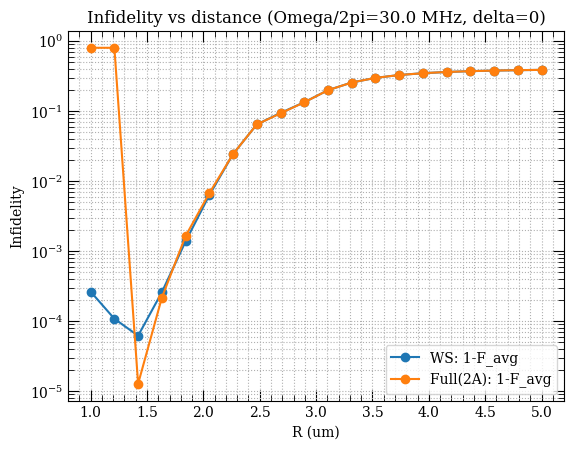

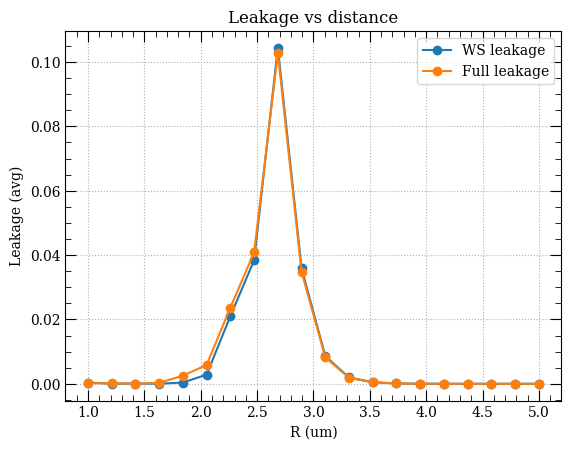

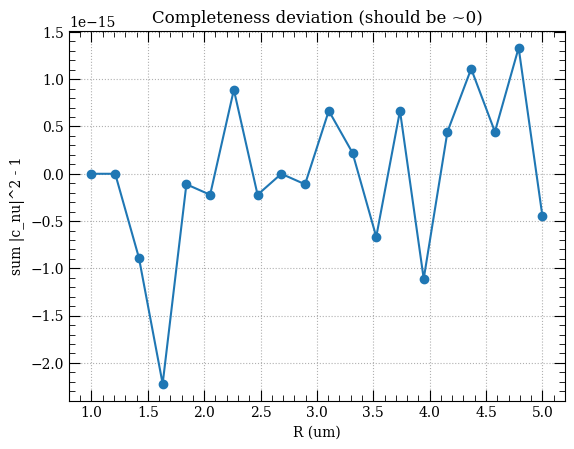

In [24]:
plt.figure()
plt.semilogy(df_R["R_um"], df_R["inf_avg_ws"], "o-", label="WS: 1-F_avg")
plt.semilogy(df_R["R_um"], df_R["inf_avg_full"], "o-", label="Full(2A): 1-F_avg")
plt.xlabel("R (um)")
plt.ylabel("Infidelity")
plt.title(f"Infidelity vs distance (Omega/2pi={Omega_2pi_MHz_default:.1f} MHz, delta=0)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

plt.figure()
plt.plot(df_R["R_um"], df_R["leak_ws"], "o-", label="WS leakage")
plt.plot(df_R["R_um"], df_R["leak_full"], "o-", label="Full leakage")
plt.xlabel("R (um)")
plt.ylabel("Leakage (avg)")
plt.title("Leakage vs distance")
plt.grid(True, ls=":")
plt.legend()
plt.show()

plt.figure()
if show_deviation_from_1:
    plt.plot(df_R["R_um"], df_R["completeness"] - 1.0, "o-")
    plt.ylabel("sum |c_nu|^2 - 1")
    plt.title("Completeness deviation (should be ~0)")
else:
    plt.plot(df_R["R_um"], df_R["completeness"], "o-")
    plt.ylabel("sum |c_nu|^2")
    plt.title("Completeness (should be ~1)")
plt.xlabel("R (um)")
plt.grid(True, ls=":")
plt.show()

## 9) Sweep 2: At R=2 um, infidelity vs Omega (and gate time)

In [ ]:
Delta0_Hz, c0, comp0 = full_spectrum_channels(calc, float(R0_um))
B0_Hz = ws_B_from_channels(Delta0_Hz, c0, Delta_floor_Hz)

rows = []
for Om_2pi in Omega_2pi_MHz_scan:
    Omega = TWOPI * MHz_to_Hz(Om_2pi)

    U_full, T = evolve_pi_2pi_pi_full(Delta0_Hz, c0, Omega, delta_Hz=0.0)
    met_full = robust_metrics_from_Ucomp(U_full)

    U_ws, _ = evolve_pi_2pi_pi_ws(B0_Hz, Omega, delta_Hz=0.0)
    met_ws = robust_metrics_from_Ucomp(U_ws)

    rows.append(dict(
        Omega_2pi_MHz=float(Om_2pi),
        T_ns=float(T*1e9),
        T_times_Omega=float(T*Omega),
        inf_avg_full=1.0-met_full["F_avg"],
        inf_avg_ws=1.0-met_ws["F_avg"],
    ))

df_Om = pd.DataFrame(rows)
print("R0 completeness:", comp0)
print("B0/2pi (MHz):", B0_Hz/1e6/TWOPI)
df_Om.head()

In [ ]:
plt.figure()
plt.semilogy(df_Om["Omega_2pi_MHz"], df_Om["inf_avg_ws"], "o-", label="WS: 1-F_avg")
plt.semilogy(df_Om["Omega_2pi_MHz"], df_Om["inf_avg_full"], "o-", label="Full(2A): 1-F_avg")
plt.xlabel("Omega/2pi (MHz)")
plt.ylabel("Infidelity")
plt.title(f"Infidelity vs Omega at R={R0_um:.1f} um (delta=0)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(df_Om["T_ns"], df_Om["inf_avg_ws"], "o-", label="WS: 1-F_avg")
plt.semilogy(df_Om["T_ns"], df_Om["inf_avg_full"], "o-", label="Full(2A): 1-F_avg")
plt.xlabel("Gate time T (ns)")
plt.ylabel("Infidelity")
plt.title(f"Infidelity vs gate time at R={R0_um:.1f} um (delta=0)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

print("Check T*Omega ~ 4*pi =", 4*np.pi)
print("Observed T*Omega min/max:", df_Om["T_times_Omega"].min(), df_Om["T_times_Omega"].max())

## 10) Sweep 3: Detuning scan (cache spectra per R for speed, identical physics)

In [14]:
# Cache spectra and WS B once per R
spectra_cache = {}
for R in R_um_grid:
    Delta_Hz, c_nu, comp = full_spectrum_channels(calc, float(R))
    B_Hz = ws_B_from_channels(Delta_Hz, c_nu, Delta_floor_Hz)
    spectra_cache[float(R)] = (Delta_Hz, c_nu, comp, B_Hz)

rows = []
for d2pi in delta_2pi_MHz_scan:
    delta_Hz = MHz_to_Hz(d2pi)
    for R in R_um_grid:
        Delta_Hz, c_nu, comp, B_Hz = spectra_cache[float(R)]

        U_full, _ = evolve_pi_2pi_pi_full(Delta_Hz, c_nu, Omega_default, delta_Hz=delta_Hz)
        met_full = robust_metrics_from_Ucomp(U_full)

        U_ws, _ = evolve_pi_2pi_pi_ws(B_Hz, Omega_default, delta_Hz=delta_Hz)
        met_ws = robust_metrics_from_Ucomp(U_ws)

        rows.append(dict(
            delta_2pi_MHz=float(d2pi),
            R_um=float(R),
            inf_avg_full=1.0-met_full["F_avg"],
            inf_avg_ws=1.0-met_ws["F_avg"],
        ))

df_d = pd.DataFrame(rows).sort_values(["delta_2pi_MHz","R_um"]).reset_index(drop=True)
df_d.head()

,delta_2pi_MHz,R_um,inf_avg_full,inf_avg_ws
0,0.0,1.000000,0.800004,0.000032
1,0.0,1.444444,0.000015,0.000057
2,0.0,1.888889,0.001586,0.001255
3,0.0,2.333333,0.022635,0.022479
4,0.0,2.777778,0.092831,0.093667


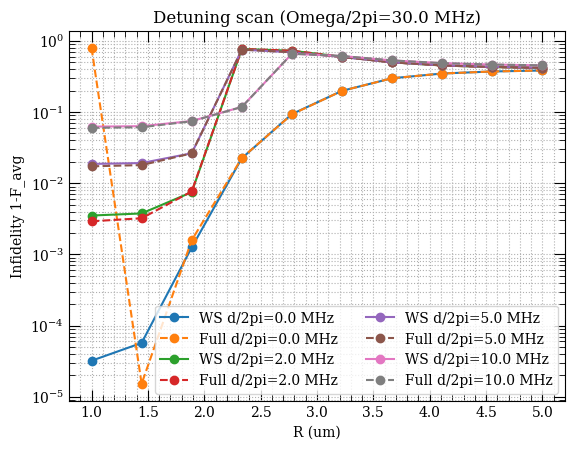

In [15]:
plt.figure()
for d2pi in delta_2pi_MHz_scan:
    sub = df_d[df_d["delta_2pi_MHz"]==float(d2pi)]
    plt.semilogy(sub["R_um"], sub["inf_avg_ws"], "o-", label=f"WS d/2pi={d2pi:.1f} MHz")
    plt.semilogy(sub["R_um"], sub["inf_avg_full"], "o--", label=f"Full d/2pi={d2pi:.1f} MHz")
plt.xlabel("R (um)")
plt.ylabel("Infidelity 1-F_avg")
plt.title(f"Detuning scan (Omega/2pi={Omega_2pi_MHz_default:.1f} MHz)")
plt.grid(True, which="both", ls=":")
plt.legend(ncol=2)
plt.show()

## 11) Optional parallel sweep over R (does not change physics)

In [ ]:
# Thread controls to reduce numerical non-determinism from multi-threaded BLAS
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

try:
    from joblib import Parallel, delayed
    HAS_JOBLIB = True
except Exception as e:
    HAS_JOBLIB = False
    print("joblib not available:", e)

def compute_one_R_row(R_value, Omega, delta_Hz):
    Delta_Hz, c_nu, comp = full_spectrum_channels(calc, float(R_value))
    U_full, T = evolve_pi_2pi_pi_full(Delta_Hz, c_nu, Omega, delta_Hz)
    met_full = robust_metrics_from_Ucomp(U_full)

    B_Hz = ws_B_from_channels(Delta_Hz, c_nu, Delta_floor_Hz)
    U_ws, _ = evolve_pi_2pi_pi_ws(B_Hz, Omega, delta_Hz)
    met_ws = robust_metrics_from_Ucomp(U_ws)

    return dict(
        R_um=float(R_value),
        completeness=float(comp),
        B_Hz=float(B_Hz),
        T_ns=float(T*1e9),
        inf_avg_full=1.0-met_full["F_avg"],
        inf_avg_ws=1.0-met_ws["F_avg"],
    )

In [ ]:
if HAS_JOBLIB:
    n_jobs = -1  # set e.g. 4 to limit cores
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_one_R_row)(R, Omega_default, 0.0) for R in R_um_grid
    )
    df_R_par = pd.DataFrame(results).sort_values("R_um").reset_index(drop=True)
    df_R_par
else:
    print("Skipping parallel run (joblib missing).")